# Agents
https://docs.langchain.com/oss/python/langchain/agents  

智能体将语言模型与工具相结合，创建出能够对任务进行推理、决定使用哪些工具并迭代地朝着解决方案努力的系统。  
create_agent提供了一个可用于生产环境的智能体实现。  
LLM智能体通过循环运行工具来实现目标。智能体会一直运行，直到满足停止条件：即当模型输出最终结果或达到迭代限制时。  
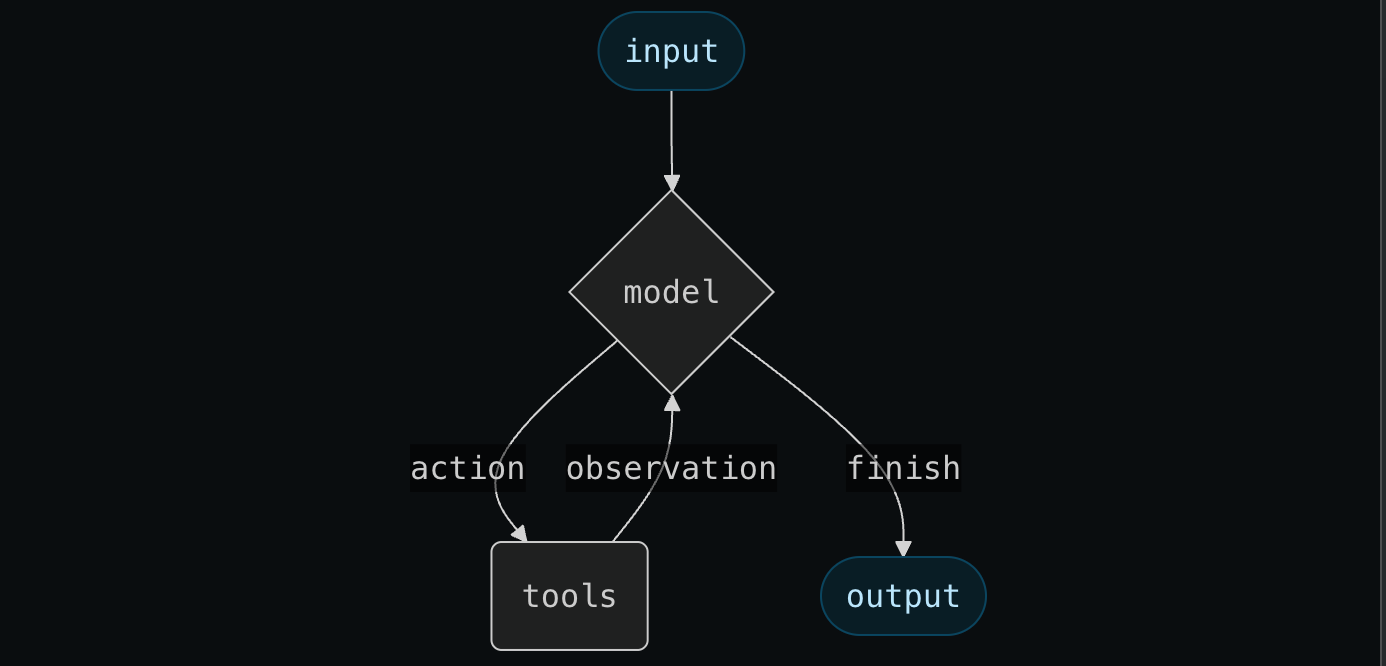
## 核心组件
### 模型
#### 静态模型
```python
from langchain.agents import create_agent

agent = create_agent(
    "gpt-5",
    tools=tools
)
```

```python
from langchain.agents import create_agent
from langchain_openai import ChatOpenAI

model = ChatOpenAI(
    model="gpt-5",
    temperature=0.1,
    max_tokens=1000,
    timeout=30
    # ... (other params)
)
agent = create_agent(model, tools=tools)
```
参数：https://docs.langchain.com/oss/python/langchain/models#parameters

模型提供商：https://docs.langchain.com/oss/python/integrations/providers/all_providers

#### 动态模型
动态模型会在运行时根据当前状态和上下文进行选择。这实现了复杂的路由逻辑和成本优化。

要使用动态模型，请使用**@wrap_model_call**装饰器创建中间件，以修改请求中的模型：
```python
from langchain_openai import ChatOpenAI
from langchain.agents import create_agent
from langchain.agents.middleware import wrap_model_call, ModelRequest, ModelResponse


basic_model = ChatOpenAI(model="gpt-4o-mini")
advanced_model = ChatOpenAI(model="gpt-4o")

@wrap_model_call
def dynamic_model_selection(request: ModelRequest, handler) -> ModelResponse:
    """Choose model based on conversation complexity."""
    message_count = len(request.state["messages"])

    if message_count > 10:
        # Use an advanced model for longer conversations
        model = advanced_model
    else:
        model = basic_model

    return handler(request.override(model=model))

agent = create_agent(
    model=basic_model,  # Default model
    tools=tools,
    middleware=[dynamic_model_selection]
)
```
**注意**  
使用结构化输出时，不支持预绑定模型（已调用bind_tools的模型）。如果需要结合结构化输出进行动态模型选择，请确保传递给中间件的模型未进行预绑定。

### 工具
工具使智能体能够采取行动。智能体超越了简单的仅模型工具绑定，具体体现在：
- （由单个提示触发的）多轮工具调用序列
- 在适当情况下的并行工具调用
- 基于先前结果的动态工具选择
- 工具重试逻辑和错误处理
- 跨工具调用的状态持久性

#### 工具定义
工具可以被指定为普通的Python函数或协程。  
工具装饰器可用于自定义工具名称、描述、参数模式和其他属性。

```python
from langchain.tools import tool
from langchain.agents import create_agent


@tool
def search(query: str) -> str:
    """Search for information."""
    return f"Results for: {query}"

@tool
def get_weather(location: str) -> str:
    """Get weather information for a location."""
    return f"Weather in {location}: Sunny, 72°F"

agent = create_agent(model, tools=[search, get_weather])
```
#### 工具错误处理
要自定义工具错误的处理方式，请使用**@wrap_tool_call**装饰器来创建中间件：
```python
from langchain.agents import create_agent
from langchain.agents.middleware import wrap_tool_call
from langchain.messages import ToolMessage


@wrap_tool_call
def handle_tool_errors(request, handler):
    """Handle tool execution errors with custom messages."""
    try:
        return handler(request)
    except Exception as e:
        # Return a custom error message to the model
        return ToolMessage(
            content=f"Tool error: Please check your input and try again. ({str(e)})",
            tool_call_id=request.tool_call["id"]
        )

agent = create_agent(
    model="gpt-4o",
    tools=[search, get_weather],
    middleware=[handle_tool_errors]
)
```
当工具失败时，代理将返回一条包含自定义错误消息的ToolMessage：  
```json
[
    ...
    ToolMessage(
        content="Tool error: Please check your input and try again. (division by zero)",
        tool_call_id="..."
    ),
    ...
]
```
ReAct循环中的工具使用
智能体遵循ReAct（“推理+行动”）模式，在带有针对性工具调用的简短推理步骤之间交替进行，并将产生的观察结果纳入后续决策中，直到能够给出最终答案。

### 系统提示词
您可以通过提供提示词来塑造您的智能体处理任务的方式。**system_prompt**参数可以传递字符串或SystemMessage：
当未提供system_prompt时，智能体将直接从消息中推断其任务。
```python
agent = create_agent(
    model,
    tools,
    system_prompt="You are a helpful assistant. Be concise and accurate."
)
```

#### 动态系统提示词
对于需要根据运行时上下文或Agent状态修改系统提示词的更高级用例，您可以使用中间件。
**@dynamic_prompt**装饰器会创建中间件，该中间件根据模型请求生成系统提示：
```python
from typing import TypedDict

from langchain.agents import create_agent
from langchain.agents.middleware import dynamic_prompt, ModelRequest


class Context(TypedDict):
    user_role: str

@dynamic_prompt
def user_role_prompt(request: ModelRequest) -> str:
    """Generate system prompt based on user role."""
    user_role = request.runtime.context.get("user_role", "user")
    base_prompt = "You are a helpful assistant."

    if user_role == "expert":
        return f"{base_prompt} Provide detailed technical responses."
    elif user_role == "beginner":
        return f"{base_prompt} Explain concepts simply and avoid jargon."

    return base_prompt

agent = create_agent(
    model="gpt-4o",
    tools=[web_search],
    middleware=[user_role_prompt],
    context_schema=Context
)

# The system prompt will be set dynamically based on context
result = agent.invoke(
    {"messages": [{"role": "user", "content": "Explain machine learning"}]},
    context={"user_role": "expert"}
)
```

### 结构化输出
https://docs.langchain.com/oss/python/langchain/structured-output  
在某些情况下，你可能希望代理以特定格式返回输出。LangChain通过response_format参数提供了结构化输出的策略。

#### ToolStrategy
`ToolStrategy`利用手动工具调用生成结构化输出。这适用于任何支持工具调用的模型：
```python
from pydantic import BaseModel
from langchain.agents import create_agent
from langchain.agents.structured_output import ToolStrategy

class ContactInfo(BaseModel):
    name: str
    email: str
    phone: str

agent = create_agent(
    model="gpt-4o-mini",
    tools=[search_tool],
    response_format=ToolStrategy(ContactInfo)
)

result = agent.invoke({
    "messages": [{"role": "user", "content": "Extract contact info from: John Doe, john@example.com, (555) 123-4567"}]
})

result["structured_response"]
ContactInfo(name='John Doe', email='john@example.com', phone='(555) 123-4567')
```

#### ​ProviderStrategy
`ProviderStrategy`使用模型提供商的原生结构化输出能力。这更可靠，但仅适用于支持原生结构化输出的提供商（例如，OpenAI）：
```python
from langchain.agents.structured_output import ProviderStrategy

agent = create_agent(
    model="gpt-4o",
    response_format=ProviderStrategy(ContactInfo)
)
```
> 从langchain 1.0开始，仅传递一个模式（例如，`response_format=ContactInfo`）不再受支持。你必须明确使用`ToolStrategy`或`ProviderStrategy`。

### 记忆
智能体通过消息状态自动保存对话历史。你也可以配置智能体使用自定义状态模式，以在对话过程中记住额外信息。  
状态中存储的信息可以被视为智能体的短期记忆。自定义状态模式必须作为TypedDict扩展AgentState。  
有两种定义自定义状态的方式：  
1. 通过`middleware`（推荐）
2. 通过`create_agent`的`state_schema`参数

### 通过中间件定义状态
当你的自定义状态需要被特定的中间件钩子以及附加到该中间件的工具访问时，请使用中间件来定义自定义状态。
```python
from langchain.agents import AgentState
from langchain.agents.middleware import AgentMiddleware
from typing import Any


class CustomState(AgentState):
    user_preferences: dict

class CustomMiddleware(AgentMiddleware):
    state_schema = CustomState
    tools = [tool1, tool2]

    def before_model(self, state: CustomState, runtime) -> dict[str, Any] | None:
        ...

agent = create_agent(
    model,
    tools=tools,
    middleware=[CustomMiddleware()]
)

# 该智能体现在可以追踪消息之外的额外状态
result = agent.invoke({
    "messages": [{"role": "user", "content": "I prefer technical explanations"}],
    "user_preferences": {"style": "technical", "verbosity": "detailed"},
})
```

#### 通过state_schema定义状态
使用`state_schema`参数作为快捷方式来定义仅在工具中使用的自定义状态。
```python
from langchain.agents import AgentState

class CustomState(AgentState):
    user_preferences: dict

agent = create_agent(
    model,
    tools=[tool1, tool2],
    state_schema=CustomState
)
# 该智能体现在可以追踪消息之外的额外状态
result = agent.invoke({
    "messages": [{"role": "user", "content": "I prefer technical explanations"}],
    "user_preferences": {"style": "technical", "verbosity": "detailed"},
})
```

In [ ]:
from pydantic import BaseModel, Field
from langchain.agents import create_agent


class ContactInfo(BaseModel):
    """Contact information for a person."""
    name: str = Field(description="The name of the person")
    email: str = Field(description="The email address of the person")
    phone: str = Field(description="The phone number of the person")

agent = create_agent(
    model="gpt-5",
    response_format=ContactInfo  # Auto-selects ProviderStrategy
)

result = agent.invoke({
    "messages": [{"role": "user", "content": "Extract contact info from: John Doe, john@example.com, (555) 123-4567"}]
})

print(result["structured_response"])
# ContactInfo(name='John Doe', email='john@example.com', phone='(555) 123-4567')